In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

from features import categorical_features, skewed_features, unskewed_features, cols_idxs
from scores import save_score

# Support Vector Regression

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df_typo = df["typology"] # needed for stratification below

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 54)
y_train.shape = (1756,)
X_test.shape = (440, 54)
y_test.shape = (440,)


## RBF Kernel

In [4]:
categorical_idxs = cols_idxs(df_train.drop(columns="po_value"), categorical_features)
skewed_idxs = cols_idxs(df_train.drop(columns="po_value"), skewed_features)
unskewed_idxs = cols_idxs(df_train.drop(columns="po_value"), unskewed_features)

preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    (PowerTransformer(standardize=True), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

svr_rbf = make_pipeline(preprocessor, SVR(kernel="rbf"))
svr_rbf.fit(X_train, y_train)
svr_rbf_test_pred = svr_rbf.predict(X_test)
print("With default params:")
print("SVR (rbf) MAE = {:.3f}".format(mean_absolute_error(y_test, svr_rbf_test_pred)))
print("SVR (rbf) R^2 = {:.3f}".format(svr_rbf.score(X_test, y_test)))

C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


With default params:
SVR (rbf) MAE = 0.156
SVR (rbf) R^2 = 0.725


In [5]:
parameters = {
    "svr__C": np.logspace(-5, 5, 31),
    "svr__gamma": np.logspace(-10, 0, 11)
}
gcv_rbf = GridSearchCV(svr_rbf, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv_rbf.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv_rbf.best_params_)) # {'svr__C': 21.54434690031882, 'svr__gamma': 0.001}
print("Best MAE = {:.3f}".format(-gcv_rbf.best_score_)) #  0.1630.158

C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Grid search / cross-validation:
Best params = {'svr__C': 21.54434690031882, 'svr__gamma': 0.001}
Best MAE = 0.158


In [6]:
gcv_rbf_test_pred = gcv_rbf.predict(X_test)
gcv_rbf_test_mae = mean_absolute_error(y_test, gcv_rbf_test_pred)
gcv_rbf_test_r2 = r2_score(y_test, gcv_rbf_test_pred)
print("On test data:")
print("Tuned SVR MAE = {:.3f}".format(gcv_rbf_test_mae))
print("Tuned SVR R^2 = {:.3f}".format(gcv_rbf_test_r2))
save_score("svr_rbf", gcv_rbf_test_mae, gcv_rbf_test_r2, os.path.join("data","results", "model_scores.csv"))

On test data:
Tuned SVR MAE = 0.149
Tuned SVR R^2 = 0.759


In [7]:
sns.set_style('whitegrid')
def validationcurve_plot(name, param_range, train_scores, valid_scores, ax):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
    ax.set_title("Validation curve for " + name)

    best_idx = valid_scores_mean.argmin()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

In [8]:
svr_rbf_2 = make_pipeline(preprocessor, SVR(kernel="rbf", gamma=gcv_rbf.best_params_["svr__gamma"]))
param_range = np.logspace(-5, 5, 31)
train_scores, valid_scores = validation_curve(svr_rbf_2, X_train, y_train, param_name="svr__C",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

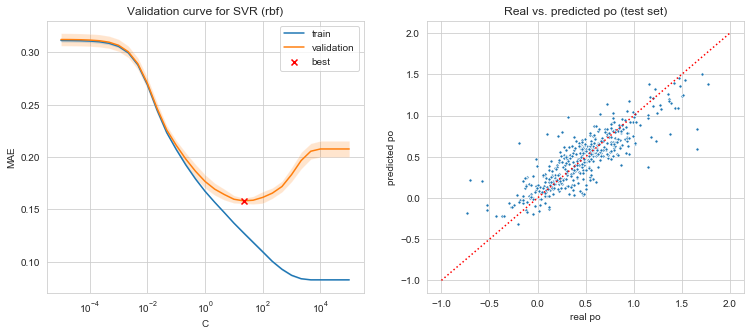

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("SVR (rbf)", param_range, -train_scores, -valid_scores, ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("MAE")
sns.scatterplot(y_test, svr_rbf_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

## Polynomial Kernel

In [ ]:
svr_poly = make_pipeline(preprocessor, SVR(kernel="poly", degree=3))
svr_poly.fit(X_train, y_train)
svr_poly_test_pred = svr_poly.predict(X_test)
print("With default params:")
print("SVR (poly) MAE = {:.3f}".format(mean_absolute_error(y_test, svr_poly_test_pred)))
print("SVR (poly) R^2 = {:.3f}".format(r2_score(y_test, svr_poly_test_pred)))

In [ ]:
parameters = {
    "svr__degree": [1, 2],
    "svr__C": np.logspace(-5, 5, 31),
    "svr__gamma": np.logspace(-10, 0, 11)
}
gcv_poly = GridSearchCV(svr_poly, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, verbose=True)
gcv_poly.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv_poly.best_params_)) # 
print("Best MAE (poly)= {:.3f}".format(-gcv_poly.best_score_)) #  